### This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi

In [3]:
kuaizi.set_matplotlib(style='nature', usetex=False, dpi=100)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [194]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')

In [195]:
pca_coeff = np.load('./train_sed/pca_coeffs.npy')
params = np.load('./train_sed/pca_params.npy')

# Normalize
pca_coeff_shift = np.mean(pca_coeff, axis=0)
pca_coeff_scale = np.std(pca_coeff, axis=0)
pca_coeff_scale[pca_coeff_scale == 0] = pca_coeff_scale[pca_coeff_scale == 0]

# params_shift = np.mean(params, axis=0)
# params_scale = np.std(params, axis=0)
# params_scale[params_scale == 0] = 1 # params_shift[params_scale == 0]

# pca_coeff = (pca_coeff - pca_coeff_shift) / pca_coeff_scale
# params = (params - params_shift) / params_scale

### Build NN emulator with FC

In [196]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, DataLoader

In [197]:
from popsed.speculator import Network

In [198]:
# Translate data to tensor
x = torch.FloatTensor(params)
y = torch.FloatTensor(pca_coeff)
dataset = TensorDataset(x, y)
train_data, val_data = torch.utils.data.random_split(dataset, 
                                                     [1200, 400], 
                                                     generator=torch.Generator().manual_seed(42))

In [199]:
dataloaders = {}
dataloaders['train'] = DataLoader(train_data, batch_size=64, shuffle=True) # batch size is the size for each batch
dataloaders['val'] = DataLoader(val_data, batch_size=64) # batch size is the size for each batch

In [200]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2b834f048610>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x2b834f048a60>}

$$a(\vec{x}) = [\vec{\beta} + (1 + \exp(-\vec{\alpha} \cdot \vec{x}))^{-1} (\vec{1} - \vec{\beta})] \cdot \vec{x}$$

In [90]:
def train_model(model, dataloaders):
    '''
    Train the model on the given dataloader
    '''
    train_loss_history = []
    val_loss_history = []
    
    learning_rate = 0.002
    epochs = 250
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        running_loss = 0.0
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = Variable(inputs)
                labels = Variable(labels)
            
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            
            if epoch % 10 == 0:
                print('Epoch: {} - {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))

    return train_loss_history, val_loss_history

In [210]:
net = Network(9, [256, 256, 256], 30)

In [209]:
torch.FloatTensor(pca_coeff_scale).shape

torch.Size([30])

In [214]:
outputs = net(torch.ones([12, 9]))

In [92]:
train_loss_history, val_loss_history = train_model(net, dataloaders)

Epoch: 0 - train Loss: 0.0196
Epoch: 0 - val Loss: 0.0760
Epoch: 10 - train Loss: 0.0117
Epoch: 10 - val Loss: 0.0440
Epoch: 20 - train Loss: 0.0101
Epoch: 20 - val Loss: 0.0376
Epoch: 30 - train Loss: 0.0092
Epoch: 30 - val Loss: 0.0337
Epoch: 40 - train Loss: 0.0087
Epoch: 40 - val Loss: 0.0312
Epoch: 50 - train Loss: 0.0079
Epoch: 50 - val Loss: 0.0286
Epoch: 60 - train Loss: 0.0079
Epoch: 60 - val Loss: 0.0278
Epoch: 70 - train Loss: 0.0079
Epoch: 70 - val Loss: 0.0281
Epoch: 80 - train Loss: 0.0078
Epoch: 80 - val Loss: 0.0272
Epoch: 90 - train Loss: 0.0075
Epoch: 90 - val Loss: 0.0263
Epoch: 100 - train Loss: 0.0075
Epoch: 100 - val Loss: 0.0258
Epoch: 110 - train Loss: 0.0079
Epoch: 110 - val Loss: 0.0270
Epoch: 120 - train Loss: 0.0072
Epoch: 120 - val Loss: 0.0252
Epoch: 130 - train Loss: 0.0070
Epoch: 130 - val Loss: 0.0239
Epoch: 140 - train Loss: 0.0074
Epoch: 140 - val Loss: 0.0253
Epoch: 150 - train Loss: 0.0074
Epoch: 150 - val Loss: 0.0254
Epoch: 160 - train Loss: 0.006

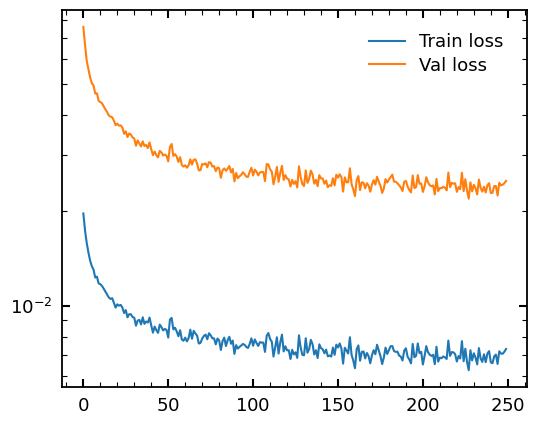

In [93]:
plt.plot(train_loss_history, label='Train loss')
plt.plot(val_loss_history, label='Val loss')
plt.legend()

plt.yscale('log')

In [367]:
import pickle

In [75]:
with open('./train_sed/pca_trained.pkl', 'rb') as f:
    pca = pickle.load(f)

In [76]:
log_spec_all = np.load('./train_sed/log_spec_all.npy')
param_all = np.load('./train_sed/param_all.npy')

In [71]:
net(x[[1100]]).detach().numpy() * pca_coeff_scale + pca_coeff_shift

array([[ 2.57691967e+00, -2.52071736e-01,  7.05716662e-03,
        -1.42363901e-03,  1.10746092e-04, -5.48496496e-04,
         4.08268759e-04, -3.07571167e-04,  3.53171249e-04,
        -1.08198561e-05]])

In [73]:
pca.training_pca[1100]

array([ 4.58946282e+00, -3.45356507e-01,  8.71410945e-03, -4.67536221e-03,
       -2.36364627e-03, -1.21215405e-03,  4.65842259e-06, -9.09626627e-04,
        5.20395215e-04, -1.28429754e-05])

In [259]:
pca.PCA.transform((log_spec_all[1100].reshape(1, -1) - pca.log_spectrum_shift) / pca.log_spectrum_scale)

array([[ 4.58946282e+00, -3.45356507e-01,  8.71410945e-03,
        -4.67536221e-03, -2.36364627e-03, -1.21215405e-03,
         4.65842259e-06, -9.09626627e-04,  5.20395215e-04,
        -1.28429754e-05]])

In [246]:
_y = pca.PCAtransform(log_spec_all[1100].reshape(1, -1) - pca.)

In [255]:
pca

IncrementalPCA(n_components=10)

In [254]:
x[1100]

tensor([ 5.0000e-02,  1.0000e+00, -5.0000e-01,  6.0000e-01,  1.0000e+00,
         9.3687e+00,  2.0000e+00,  0.0000e+00,  1.7358e-15])

In [375]:
net(x[[20]])

tensor([[ 0.3279,  1.5452, -0.6332, -2.3121, -0.3249, -0.0898,  1.9822, -1.1348,
         -1.5159,  1.2947]], grad_fn=<AddmmBackward0>)

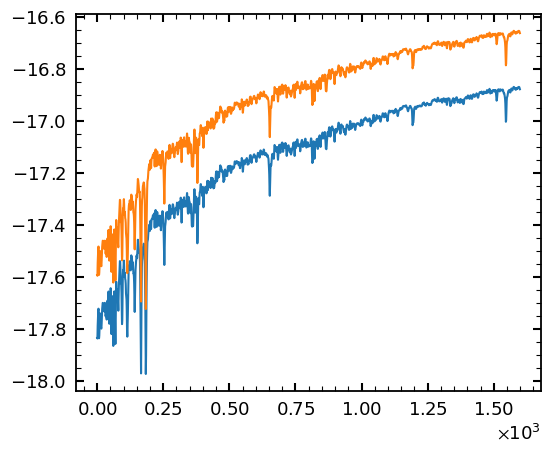

In [95]:
spec = pca.PCA.inverse_transform(
    net(x[[200]]).detach().numpy()[0] * pca_coeff_scale + pca_coeff_shift
) * pca.log_spectrum_scale + pca.log_spectrum_shift# + 1.5

plt.plot(log_spec_all[200])
plt.plot(spec)

### Test the `Speculator` class

In [340]:
from popsed.speculator import Speculator

In [366]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])

In [383]:
speculator = Speculator(n_parameters=2, n_pca_components=30, 
                        pca_filename='./train_sed/pca_trained.pkl', 
                        hidden_size=[256, 256, 256])

In [384]:
pca_coeff = np.load('./train_sed/pca_coeffs.npy')
params = np.load('./train_sed/pca_params.npy')[:, ~flag]

In [385]:
# pca_shift = np.mean(pca_coeff, axis=0)
# pca_scale = np.std(pca_coeff, axis=0)
# pca_coeff = (pca_coeff - pca_shift) / pca_scale

In [386]:
speculator.load_data(pca_coeff, params, val_frac=0.2, batch_size=128)

In [387]:
speculator.train(n_epochs=200)

Epoch: 0 - train Loss: 0.0124
Epoch: 0 - val Loss: 0.0555
Epoch: 10 - train Loss: 0.0083
Epoch: 10 - val Loss: 0.0359
Epoch: 20 - train Loss: 0.0073
Epoch: 20 - val Loss: 0.0314
Epoch: 30 - train Loss: 0.0068
Epoch: 30 - val Loss: 0.0294
Epoch: 40 - train Loss: 0.0065
Epoch: 40 - val Loss: 0.0282
Epoch: 50 - train Loss: 0.0063
Epoch: 50 - val Loss: 0.0272
Epoch: 60 - train Loss: 0.0061
Epoch: 60 - val Loss: 0.0263
Epoch: 70 - train Loss: 0.0058
Epoch: 70 - val Loss: 0.0252
Epoch: 80 - train Loss: 0.0058
Epoch: 80 - val Loss: 0.0251
Epoch: 90 - train Loss: 0.0057
Epoch: 90 - val Loss: 0.0243
Epoch: 100 - train Loss: 0.0055
Epoch: 100 - val Loss: 0.0237
Epoch: 110 - train Loss: 0.0055
Epoch: 110 - val Loss: 0.0236
Epoch: 120 - train Loss: 0.0054
Epoch: 120 - val Loss: 0.0231
Epoch: 130 - train Loss: 0.0052
Epoch: 130 - val Loss: 0.0225
Epoch: 140 - train Loss: 0.0053
Epoch: 140 - val Loss: 0.0228
Epoch: 150 - train Loss: 0.0052
Epoch: 150 - val Loss: 0.0224
Epoch: 160 - train Loss: 0.005

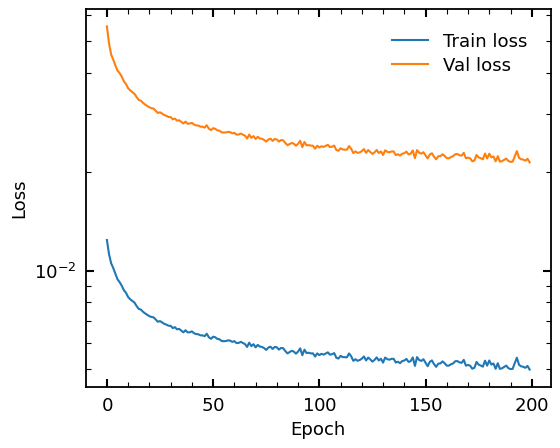

In [388]:
speculator.plot_loss()

In [397]:
params

array([[ 1.        , -2.        ],
       [ 1.        , -1.9       ],
       [ 1.        , -1.8       ],
       ...,
       [13.08810901,  1.7       ],
       [13.08810901,  1.8       ],
       [13.08810901,  1.9       ]])

In [389]:
params = np.load('./train_sed/pca_params.npy')[:, ~flag]
log_spec_all = np.load('./train_sed/log_spec_all.npy')

In [390]:
_pca_coeff = speculator.predict(params)

In [391]:
_specs = speculator.predict_spec(params)

In [392]:
pca_coeff[100]

array([ 9.30467702e+00,  4.40532397e-01, -2.11922438e-02, -1.97288860e-02,
        2.56419450e-03, -1.37360730e-03, -2.02372033e-04, -1.06844416e-03,
       -1.09613955e-03,  1.35194460e-03,  1.90912353e-04,  2.05779449e-04,
       -4.19064085e-04,  1.12769928e-04,  2.76047842e-04, -3.27564664e-05,
        6.79769798e-05, -4.31989325e-05, -6.00276877e-05,  8.08223659e-06,
        2.03618418e-05, -2.40681991e-05, -5.70388646e-05,  1.73192813e-05,
       -3.63465116e-05, -1.80770978e-05, -2.02710438e-05, -6.81908707e-07,
        3.38493622e-06,  8.87553410e-06])

In [393]:
_pca_coeff[100]

array([ 1.16711325e+01,  3.27395450e-01, -1.28425109e-02, -1.60584755e-02,
        1.88065237e-03, -6.74698887e-04,  4.35232255e-04, -6.14275639e-04,
       -6.46416586e-04,  7.45567806e-04,  1.36967161e-04,  1.05042828e-04,
       -2.57576604e-04,  8.73307662e-05,  7.92547590e-05,  5.62288353e-05,
        5.43427197e-05, -1.42302447e-05, -1.14292118e-05,  5.61227384e-06,
       -8.06476171e-06, -4.29111084e-06, -7.12075768e-06,  7.88743591e-06,
       -9.43329397e-06, -3.83919454e-06, -4.71606719e-06, -1.22805075e-06,
       -1.84590513e-06,  1.80948363e-06])

In [394]:
speculator.pca_scale

array([3.99986334e+01, 3.29345369e-01, 2.32492731e-02, 1.58397839e-02,
       7.67725650e-03, 1.67532877e-03, 1.24467181e-03, 7.54647664e-04,
       5.76133812e-04, 3.94893983e-04, 3.40301478e-04, 2.92507638e-04,
       2.35182746e-04, 1.53095774e-04, 1.43906833e-04, 9.87528630e-05,
       8.68417418e-05, 5.36572395e-05, 4.45358908e-05, 3.94903021e-05,
       3.49321679e-05, 2.68617568e-05, 2.52007936e-05, 2.15607009e-05,
       2.03424177e-05, 1.75385905e-05, 1.60992746e-05, 1.25716645e-05,
       1.08069813e-05, 8.74864615e-06])

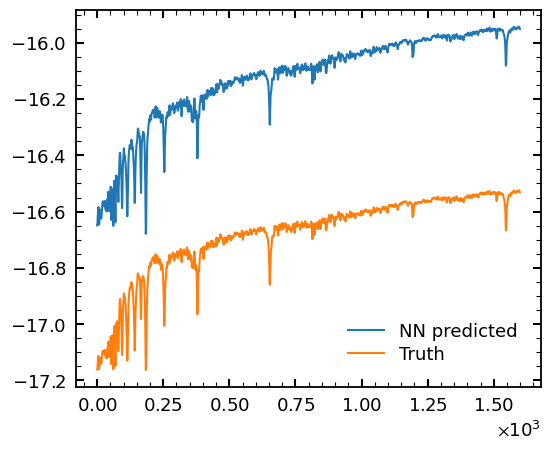

In [395]:
plt.plot(_specs[140], label='NN predicted')
plt.plot(log_spec_all[140], label='Truth')

plt.legend()